### Module import

In [7]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,resnet34
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pickle
%matplotlib inline

In [8]:
is_cuda = torch.cuda.is_available()
is_cuda

True

## Utility functions

In [9]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
    
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)
    
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

## Creating PyTorch datasets

In [6]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [11]:
train_dset = ImageFolder('C:/Users/USER/Desktop/Heo/Pytorch/chapter8/Study/20210702/data1/data_1/train/',transform=data_transform)
val_dset = ImageFolder('C:/Users/USER/Desktop/Heo/Pytorch/chapter8/Study/20210702/data1/data_1/val/',transform=data_transform)
classes=2

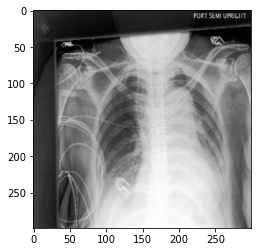

In [13]:
imshow(train_dset[151][0])

## Creating data loader for training and validation datasets

In [14]:
train_loader = DataLoader(train_dset,batch_size=16,shuffle=True,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=16,shuffle=False,num_workers=3)

In [15]:
len(train_loader)

117

## Creating ResNet 34 model

In [17]:
resnet_34 = resnet34(pretrained=True)

if is_cuda:
    resnet_34 = resnet_34.cuda()

In [18]:
m = nn.Sequential(*list(resnet_34.children())[:-1])

## Extracting Convolutional features

In [20]:
#For training data

# Stores the labels of the train data
trn_labels = [] 
trn_features = [] 

for d,la in train_loader:
    o = m(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    trn_labels.extend(la)
    trn_features.extend(o.cpu().data)

#For validation data
val_labels = []
val_features = []
for d,la in val_loader:
    o = m(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    val_labels.extend(la)
    val_features.extend(o.cpu().data)

## Creating train and validation feature dataset

In [21]:
#Creating dataset for train and validation
trn_feat_dset = FeaturesDataset(trn_features,trn_labels)
val_feat_dset = FeaturesDataset(val_features,val_labels)

#Creating data loader for train and validation
trn_feat_loader = DataLoader(trn_feat_dset,batch_size=16,shuffle=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=16)

## A Fully connected network

In [22]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self,in_size,out_size):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = self.fc(inp)
        return out

In [23]:
fc_in_size = 512

In [24]:
print(FullyConnectedModel(512,2))

FullyConnectedModel(
  (fc): Linear(in_features=512, out_features=2, bias=True)
)


In [25]:
fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.cuda()

In [32]:
optimizer = optim.Adam(fc.parameters(),lr=0.01)

In [33]:
class ResNetBasicBlock(nn.Module):
    
    def __init__(self,in_channels,out_channels,stride):
        
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        
    def forward(self,x):
        
        residual = x
        out = self.conv1(x)
        out = F.relu(self.bn1(out),inplace=True)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return F.relu(out)
        

In [34]:
print(ResNetBasicBlock(512,2,1))

ResNetBasicBlock(
  (conv1): Conv2d(512, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [35]:
print(resnet_34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train and validate the model

In [36]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.19 and training accuracy is 1813/1858     97.58
validation loss is  0.63 and validation accuracy is 210/226     92.92
training loss is 0.013 and training accuracy is 1850/1858     99.57
validation loss is  0.46 and validation accuracy is 207/226     91.59
training loss is 0.0072 and training accuracy is 1856/1858     99.89
validation loss is  0.69 and validation accuracy is 210/226     92.92
training loss is 0.0047 and training accuracy is 1856/1858     99.89
validation loss is  0.73 and validation accuracy is 210/226     92.92
training loss is 0.0042 and training accuracy is 1855/1858     99.84
validation loss is  0.81 and validation accuracy is 210/226     92.92
training loss is 0.0017 and training accuracy is 1858/1858     100.0
validation loss is  0.82 and validation accuracy is 210/226     92.92
training loss is 0.0014 and training accuracy is 1858/1858     100.0
validation loss is  0.74 and validation accuracy is 210/226     92.92
training loss is 0.001 and tr